To clone the data we make use of '!git clone' and make sure to point to the appropriate github repository. As we run this code it clones and allows us to make use of the driving data into Google Colab from the github repository. The when it is complete, using the '!ls' command to see what kind of data is inside the repository. by running it it will returns 'driving_log.csv IMG'.


In [1]:
!git clone https://github.com/mshahrasbi/Applied-Deep-Learning-Self-Driving-Car

Cloning into 'Applied-Deep-Learning-Self-Driving-Car'...
remote: Enumerating objects: 12231, done.
remote: Total 12231 (delta 0), reused 0 (delta 0), pack-reused 12231
Receiving objects: 100% (12231/12231), 188.83 MiB | 10.97 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Checking out files: 100% (12217/12217), done.


In [2]:
!ls Applied-Deep-Learning-Self-Driving-Car/Projects/14-BehaviouralCloning/simulator-windows-64/data

driving_log.csv  IMG


Before we start training a NN as always we must preprocess all of our data. First import the libraries.

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import cv2
import pandas as pd
import ntpath
import random

Using TensorFlow backend.


First, we start by readig our data with pandas, we will specify the directory datadir to 'track' . we will first manipulate and analyze the ata of our CSV file. we use Pandas pd, using 'read_csv' function, we will simply load our data from CSV file , we are going to load into the data frame, we will specify the list of column names to use. data.head() will output some rows and as you can see our images are save as complete path from our pc, so we need to split from the last item in the path being the image itself, we will import module 'ntpath'. Then we will specify a function path_leaf taking in an argument path. 

In [4]:
datadir = 'Applied-Deep-Learning-Self-Driving-Car/Projects/14-BehaviouralCloning/simulator-windows-64/data'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', -1)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_382.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_382.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_382.jpg,0.0,0.0,0.0,0.649786
1,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_670.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_670.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_670.jpg,0.0,0.0,0.0,0.627942
2,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_724.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_724.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_724.jpg,0.0,0.0,0.0,0.622910
3,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_792.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_792.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_792.jpg,0.0,0.0,0.0,0.619162
4,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_860.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_860.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_860.jpg,0.0,0.0,0.0,0.615438


In [5]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail

data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)

data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2018_07_16_17_11_43_382.jpg,left_2018_07_16_17_11_43_382.jpg,right_2018_07_16_17_11_43_382.jpg,0.0,0.0,0.0,0.649786
1,center_2018_07_16_17_11_43_670.jpg,left_2018_07_16_17_11_43_670.jpg,right_2018_07_16_17_11_43_670.jpg,0.0,0.0,0.0,0.627942
2,center_2018_07_16_17_11_43_724.jpg,left_2018_07_16_17_11_43_724.jpg,right_2018_07_16_17_11_43_724.jpg,0.0,0.0,0.0,0.622910
3,center_2018_07_16_17_11_43_792.jpg,left_2018_07_16_17_11_43_792.jpg,right_2018_07_16_17_11_43_792.jpg,0.0,0.0,0.0,0.619162
4,center_2018_07_16_17_11_43_860.jpg,left_2018_07_16_17_11_43_860.jpg,right_2018_07_16_17_11_43_860.jpg,0.0,0.0,0.0,0.615438


Now, what we are going to do is for every set of images we are going to plot the steering angles on a histogram in order to visualize the distrbution and see which steering angles are most frequent throughout the recording. We are going to do for every set of images we are going to plot the steering angles on a histogram in order to visualze the distribution and see what steering angles are most frequent throughout the recording. Visualizing the data is very important as it allows us to verify the flaws in our data and determine what types od steps are needed to correctly preprocess it for training. To construct the histogram the first step is to divide the entire range of values into intervals, we are going to bin the range of values where the number of bins is going to equal 25. Make sure this is an odd number as we will aim to obtain a centered distribution and then we will call np.histogram()

Our data goes from -1 to 1 which makes sense, as that is how we are steering angles are distributed. But notice how it is not centered around the value of 0 which would indicate no steering driving straight down the middle of the road.

Lets have our values centered around 0 and we can do this by setting a:
center = (bins[:-1] + bins[1:]) * 0.5

So what we do slice from the beginning of the array right up until the very end of the array which can be denoted as -1, so we are starting from this value and stopping at 0.92. And we will take that segment of the array and we are going to add it to another segment, which goes from the value at index 1 so -0.92 right up until the very end performing element wise addition between the 2 segments. What that will do is ultimately end up adding the values adjacentto 0, -0.04 and 0.04 resulting in centered value at 0, and at the same time this roughly doubles every other value, so to restore the appropriate range we multiply everything by 0.5.

Now we plot the bar graph.

As expected steering angles from -1 to +1 centered around a steering angle of 0. This vertical axis specifying the values of our histogram hist itself, the frequency of each steering angle during the simulation. Plotting this histogram of training data shows us that the data we obtained from driving in track one has more zeros angles because of the nature of the track as in most of the time we drove down the middle of a straight track the left and right steering anfle seemed to be pretty balanced since recall we drove in both opposing directions of the track, Had we not done that and only drove in one direction due to the nature of the track it would have a lot more left steering angles, thus our model would become very biased towards driving down left turns as opposed to the right turns. This would cause data imbalance and essentially you would obtain something like this (bar graph heavy weigth in the left side) where we would then need to include a pre-processing step toprevent the model from being biased towards the left turns. we are still going to make use of many useful techniques to process our data regardless. but it is good to know that our data is already balanced to start with but there is a huge problem however, a huge number of the angles occur at the zero angle, if we train the model based on this data this creates a problem for the NN which could bias the model towards predicting 0 angle, thus the car beomes biased towards driving straight all the time. We rarly steer and become easily confused when it encounters sharp turns. and to improve this what we are going to do is reject all the samples above a certain threshold and make sure that it is more uniform and not biased towards specific steering angle/ So what we are going to do is specify a threshold of 200 that is samples per bin is going to equal 200 meaning that every bin can only have a maximum of 200 samples to visualize the threshold we will plot it, we will specify thefirst horizontal x value as the minimum value of our range np.min data steering and the second horizontal x value will correspond to the maximum value in the horizontal range np.max data steering. Now each horizontal coordinate will be assigned vertical y value corresponding to the number of samples per bin.

what that does is plot a line with the corresponding coordinates what's under the black line represents what would be a uniform distribution of our data samples. So if we were to reject all samples that exceed 200, removing all of the samples essentially then the data won't be heavily skewed towards predicting 0 angles, rather it will have enough data of left right and middle steering angles that can be better analyzed rather than having the NN being selective in favor of one, but at the same time most of the data is still going to be in the middle which is fine since recall the initial goal is to have the car drive down the center of the road. so it is essential to capture more zero steering angles which would correspond to centered lane driving.
So we will have to flatten our data distribution accordingly which is quite the process.

[-1.   -0.92 -0.84 -0.76 -0.68 -0.6  -0.52 -0.44 -0.36 -0.28 -0.2  -0.12
 -0.04  0.04  0.12  0.2   0.28  0.36  0.44  0.52  0.6   0.68  0.76  0.84
  0.92  1.  ]


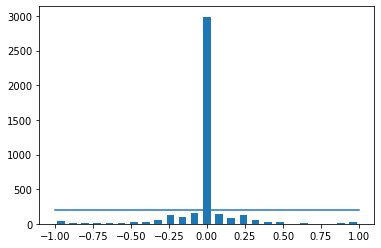

In [6]:
num_bins = 25
samples_per_bin = 200
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1] + bins[1:]) * 0.5
print(bins)
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

Here our training data is skewed towards the middle and if we were to train our CNN based on this data then the model could become biased towards driving straight all the time so we must flatten our data distribution and cut off extraneous samples for specific bins whose frequency exceed 200. In fact throughout the project we will need to perform many preprocessing techniques to ensure that our car is able to primary drive reliably throughout the entire length of the challenge track.
Well lets start by making our distribution a little more uniform, so what we are going to do is, we will specify a variable remove_list to an empty list. On this list we specify the samples we want to remove, so we will by looping through every single bin for J i the range of number of bins what we are going to do is create a list make it equal to an empty list. but for the current bin[j] that is being iterated through we will loop through the range of every single steering angle belonging t this bin that was obtained throughout driving on the track, so for i in the range of the lenght of data and we will iterate through the range of all the steering data, the first thing we want to do is isolate thesteering angles belong to the current bin being iterated through. So we will check the data if the steering data at the index being iterated through i is greater than or equal to the steering angle of the current bin that is being iterated through the bin at index j, and we also check if the steering data steering once again at the index being iterated through i, we will check if it is smaller than or equal to the steering angle at the bin that comes right after thecurrent one, j + 1. And so right there you know if the steering angle value falls in between 2 bins then it belongs to the current interval bin[j] that is being iterated through for example a steering angle of -0.97 or -0.96 0r -0.95 would all belong to the same bin. And what we will do is append each index of the steering angle value falling in the appropriate category to the list (list_.append(i)) this index will point to the steering angle i and everytime we append an index which points to a specific steering angle within our dataframe we need to shuffle our list, why? well eventually this list is going to contain all the steering angles for a specific bin, the bin that is currently being iterated through. And lets assume that throughout driving on the track we collected more than 500 steering angles that belong to this bin which means the list would contain more than 500 indices which corresponds to indices of left sterring angles from one part of the track up until the end. the threshold is 200, so assuming this has 500 samples lets say we must then reject 300 samples to make our data more uniform. So why not just cut the last 300 elements? well we can't just do that since the array recorded information about steering angles from the beginning up until the end of the track it is ordered if we cut off the last 300 elements then we lose all the information collected at the end of the track and thus we won't have any data to train the model on how to drive once it gets to the end, but if shuffle the data by re-arranging the order in which the steering angles are in the list then once we cut the last 300 elements it cuts information from all parts of the track, but by doing so we are still preserving the information from all parts of the track just enough to train our model to drive throughout the entire track. So for a specific set of steering angle values collected throughout the track what we are going to do is write lists and we will set it equal to itself, but we are going to make sure that it is shuffled. And now havinf shuffled the list now we will isolate the indices that go beyond the threshold. We do this by setting list is equal to lists, and we are going to isolate everything that goes beyond the threshold from samples per bin value 200 until end of the list, and that segment of the list that we want to remove we will dispose of it inside of the remove list, allowing us to spread the contents of what we want to dispose right on to remove list.
So after looping all of our data now we have a list which records the indices of all the steering angles we want to dispose of in order to make our distribution more uniform. So what we are going to do is to print the lenght of the amount of steering angles we are removing.
Now we will drop specific rows of data in our data frame which correspond to these indices inside of remove list with data.drop(), and we are going to set in place to true so as to have the updated value remain on the same copy. Lets then print the remaining data print remaining which will equal the length of the new updated data frame.
Now we have data which cuts off extraneous samples for specific bins whose frequency exceed 200 making our data more uniform and less biased.
Lets plot our data to get a visual using np.histogram() which is going to take in all of our steering data accessing it from a data frame as steering and whatever values we get from steering we will divide this entire range of values into 25 intervals, the numer of bins and what this does is it returns two values  we are only interested in the new updated hsitogram values 'hist' and we will leave the other one as blank, and once again plotting our bar grap and line.

The output is distribution of steering angles that are much more uniform. viewed data in relative proportion, there are significant left steering angles and significant right steering angles eliminating the extreme bias to driving straight all the time which would have been quite troublesome, this extreme bias resulted from the training as we drove the car as smoothly as possible right in the middle of road and thereby recording the ideal steering angle at all times, we fix this by cropping most of the extraneous training data, but keep in mind this could have been fixed in other ways. An alternative solution would be to let the car continously steer in either direction drifting to the edge of the road but never actually hit the edges and have it recover back to the middle before it crashes because simply driving down the middle of the road and recording and that is not enough to train your model to drive properly. Imagine the car wanders off to the side of road in such a case it wouldn't be able to recover back to the middle as it wouldn't be able to predict the appropriate left steering measurments. therefore an alternative to manipulating the data in this way is to record a recovery laps where we actually make a separate recording of the car constantly steering back from the sides, so what you would do is turn off the recording of the car or andering off to theside since that is not the behavior that we want to train the model on but only record once we are going to steer back to middle. These are known as recovery laps if once we simulate our self-driving car you fell that your car isn't able to steer back to the middle then it would be a good idea to add more data involved in these recovery laps.



total data:  4053
removed:  2790
remaining:  1263


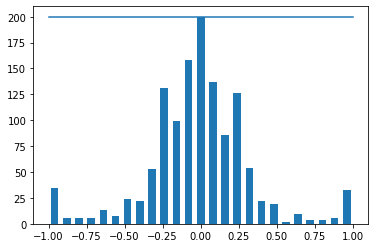

In [7]:
print('total data: ', len(data))

remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)

print('removed: ', len(remove_list))

data.drop(data.index[remove_list], inplace=True)
print('remaining: ', len(data))

hist, _ = np.histogram(data['steering'], (num_bins))

plt.bar(center, hist, width = 0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

Now since having gotten rid of the zero angle bias not completely since we still want our car to favor driving down the middle let's load our image and steering data into arrays so we are able to manipulate them and split them into training and validation data. 

we define a function 'load_image_steering' which will take in the directory variable that we specified earlier as well as data frame as arguments and in there we will specify 2 variables 'image_path' it is init as an empty list and 'steering' it is an empty list. And lets loop through the length of our updated data for in the range of the length of data, we will set an index vatiable 'indexed_data', the data is equal to data.iloc, iloc is allow us to perform a selection on a row of data from our data frame based on the specific index which will simply be the current index that is being iterated through i, 'indexed_data' would therefore contain a specific row of data at each iteration and you could simulate this by printing data at some location 1 (i guess) and what it outputs is the row at index 1 with a set of images that correspond to a specific steering angle, and now from that row of data we want to access the center left and right images, so accordingly we set center left and right (and it looks like the images are indices 0, 1, 2 respectively) is equal to indexed_data[0], indexed_data[1] , indexed_data[2], and for now we are going to work with the center images, so append all of them into the list called 'image_path' and inside the list while we place every single center image we are also going to be appending into it, the main path from data dir that we pass in, so we set 'image_path' and append into it using os.path.join and we join the 'datadir' that we will be passing in with the corresponding image name itself, center, and we also make use of the strip method, and what this will do is eliminate any spaces that may be present in the string.
  
  track/IMG/center_2018....

giving us the path for each image and this path allows us to access and reference all the images that we cloned from our repository. Now in the next list is where we append all the steering angles where steering is going to 
steering append all the steering angles and as you can see they are all in index 3 of 'indexed_data'. Now out of for loop what we are going to do is convert these lists into arrays, that way they can be better manipulated.Now what will do is simply return the arrays or the array containing our images as well as the steering array.
And now what will do is simply call the function 'load_image_steering' passing the directory that we created plus IMG, so as to properly reference the image paths and also passing in the updated data the required data, and now we will set image_paths and steering is equal to the return value of this function


In [8]:
print(data.iloc(1))
def load_image_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))

  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)

  return image_paths, steerings

image_paths, steerings = load_image_steering(datadir + '/IMG', data)

Now we have 2 arrays, one array for the images in another array containing each image's  corresponding label each image its corresponding steering angle. Having done so we need to split these arrays into random training and validation datasets. And sowhat we will do is make use of a utilty from sklearn known as 'train_test_split'. We will make use of this function to splitting the image_paths as well as steerings arrays, and we must specify a test size which simply corresponds to the proportion of our current dataset that i want to include in the test splits, by default the proportion is 1/4 and so we will make use of 0.2, I found that ro be a reasonable split into the test data or validation data in the case, and we will set a random_state is equal to 6.

Now if you following along with the data that I provided for you in github then probably best if you use the same seed as I do. And the seed is simply used by the random number generator. Randomizing the way in which the data is split, you can specify any seed that you want but if you are using my data and you want consitent results then I envourage you use the same seed and will return the split data into the training image data X_train, validation image data X_valid, the corresponding training labels y_train and the validation lables respectively y_valid. And after doing so all the data that we have collected from the simulation are now split into training and validation data each image for each set of data corresponding to a specific steering angle.

After we print them, outputting this clearly there are roughly 1200 samples of data 20% of it split into validation and now having split our data let's ensure that both datasets include a uniform distribution of steering angle such that both left and right steering angles are balanaced and also such that the model is a little bit more biased towards predicting a zero angle which would essentially be representative of the data we collected while driving. 
And so we are going to have 2 histpr=grams one for each data set.

In [9]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size = 0.2, random_state = 6)
print('Training Sample: {}\nValid Smaples: {}'.format(len(X_train), len(X_valid)))

Training Sample: 1010
Valid Smaples: 253


Text(0.5, 1.0, 'Validation set')

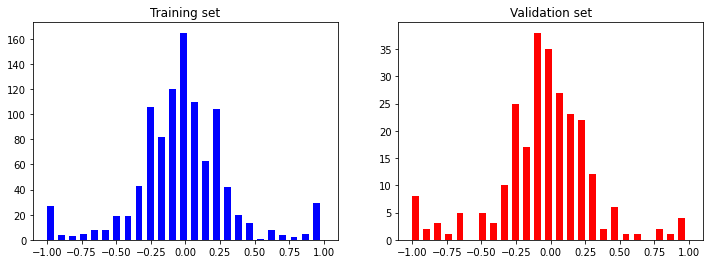

In [10]:
fig, axes = plt.subplots(1, 2,figsize=(12, 4))
axes[0].hist(y_train, bins = num_bins, width = 0.05, color = 'blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins = num_bins, width = 0.05, color = 'red')
axes[1].set_title('Validation set')


it is clear that the data isn't exactly similar but both follow a general trend such that both right and left steering angles are somewhat balanced they are pretty balanced, yet the data is still somewhat biased towards the center, meaning that splitting our data was successful will train the NN based on the training data to learn the appropriate steering angles according to which part of the track it is in, extracting the necessary features and then test it on the validation set to determine whether our neural model is underfitting  or overfitting based on the steering angles predicted by the NN in comparsion to the actual steering angles.

So we used the 'train_test_split' function to split a portion our trainin gdata into validation data, this is going to help us evalate the quality of the training process that our model will go through, we will also be able to judge our models performance by assessing our models validation loss. Now we mode on to actually pre-processing our data and preparing it for use inside of our Neural model. 

Lets begin by defining a preprocessing function and we will call this function 'img_preprocess', this function will also be designed to take in one argument namely an img which is simply going to be the image that gets processed. Now as our dataset simply consists of image paths the image object we import into this function is going to be image path, so the first step we need to take is to read this image path and store the actual image that it contains, we can use 'mpimg.imread(img)' and store the value that was read into another variable that we wii also call 'img', this function 'img_preprocess' also return the same image after it has beed preprocessed.

Now that we have a pre-processing function we need to actually decide what kind of preprocessing techniqueswe need to implement on our images. So visualize our original images alongside our preprocessed images.

So first select a random image from our training dataset to visualize, we can store this inside a varaible that we will call 'image'. In order to compare our original image with our preprocessed image we need to define 2 images independently for our 'original_image', read out=r image path 'mpimg.imread(image)' and store it inside our 'original_image' variable. and for our 'preprocessed_image' we simply feed  our image_path into our 'img_preprocess(image)'. And now we defined the both of our images we simply need to plot them side by side.

In [0]:
def img_preprocess_step1(img):
  img = mpimg.imread(img)
  # start modify the img
 
  return img

Text(0.5, 1.0, 'Preprocessed Image')

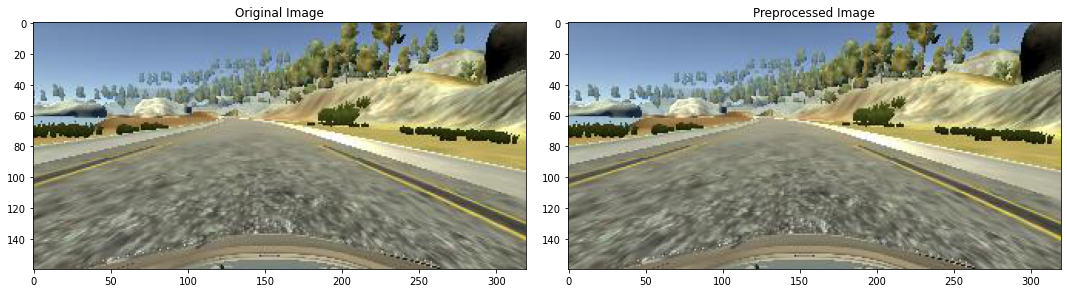

In [12]:
image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess_step1(image)
#
fig, axs = plt.subplots(1, 2, figsize = (15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')

Text(0.5, 1.0, 'Preprocessed Image')

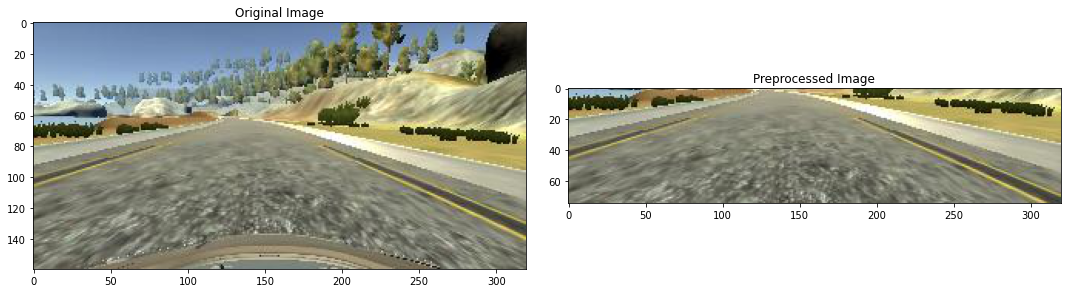

In [13]:
def img_preprocess_step2(img):
  img = mpimg.imread(img)
  # start modify the img
  img = img[60:135, :, :]
  return img

# image = image_paths[100]
# original_image = mpimg.imread(image)
preprocessed_image = img_preprocess_step2(image)
#
fig, axs = plt.subplots(1, 2, figsize = (15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')

So these two images are identical, our axes shows that our original image has a dimension of 320X160, Now we can determine the preprocessing techniques that we need to add to our dataset. Revisiting the cell containing our pre-processing function we can start modifying it accordingly. Looking at our image we can see that there are a lot of features that are not very important to focus on, for eaxmple the top of our image is almost entirely just senery consisting of trees and mountains, while the very bottom of our image is just the hood or our own car these features are not relevant for helping our car determine the steering angle as there is no relationship between the scenery surrounding the road and the steering angle of our car. for this reason we can crop our image to remove it these noise these unnecessary features, this can be done using simple numpy array slicing. Our image is essentialy just a 3D array which contains a height , width and a channel index as we are only concerned with cropping our image height, we can leave the remaining indices as full slices. the width and channel and will remain the same. Now we need to decide how much of the height of the image we want to crop. So back to our image plot our axis shows at the top of our image has a value of 0 while the bottom of our image has a value of 160 at a value of approximately 60 we can see that we can crop our all the unnecessary features on top of the image and on the lower end of our image we simply want to crop out the hood of our car. Te hood of the car begins at an approximate value of 135, which means that we want to remove everything below this value, therefore we simply slice the height of our image from 60 to 135.

So running the above cell and re-plotting our images allow us to see newly cropped image, as you can see the unnecessary features were removed. This will allow our model to focus on the more important features of the image such as the lane lines and the borders.

The next step is to change the color space of our image. previously we used a modified Lenet model to classify our traffic sign data. However as mentioned earlier there are many other neural architectures that we can choose from, here we are going to rely on the more complex 'invidia' model. This however is relevant for preprocessing because the nvidia model architects themselves recommend that we use the YUV color space for our a dataset as opposed to the default RGB format or even a grayscale image. Fir this reason we will also convert our color space to YUV. This can be done using the familiar 'cv2.cvtColor' function withour image as the first argumentand then we use the flag 'cv2.COLOR_RGB2YUV' which is going to convert our image from RGB to YUV. We can then store this inside our image variable and the YUV the color space might be unfamiliar to you. However it simply consists of 3 channels much like the RGB color space. 
Y represent the luminosity or brightness of the image, while the UV components represent chromium which add colors to the image. 
Lets run it again and see the impact of this conversion on our image.

Text(0.5, 1.0, 'Preprocessed Image')

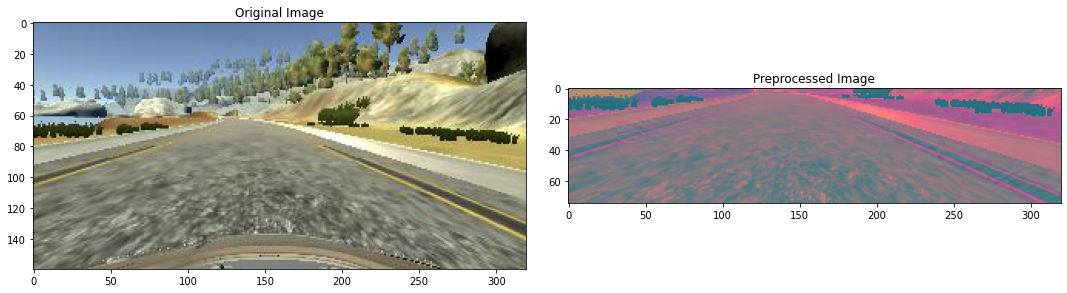

In [14]:
def img_preprocess_step3(img):
  img = mpimg.imread(img)
  # start modify the img
  img = img[60:135, :, :]
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  return img

# image = image_paths[100]
# original_image = mpimg.imread(image)
preprocessed_image = img_preprocess_step3(image)
#
fig, axs = plt.subplots(1, 2, figsize = (15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')

As you can see our image looks very different now, however as mentioned earlier experts say that this color space is very effective for use in training an invidia neural model.

The next technique we are going to use is the addition of a Gaussian Blur. This will applied using 'cv2.GaussianBlur' function, it is useful to apply an image beacause ithelps smoothing the image out and to reduce noise within the image, it works by applying a Gaussian kernel convolution on our image and recall that we discussed this function in full detail in our finding laneline section.
The first argument is image, the next argument isthe size of our Gaussian kernel, we are going to use a relatively small kernel with a size of 3X3, and finally we will leave the deviation of the kernel as zero as it is not very necessary to us in this case, and let's just set this equal to img returning thefollowing variable, and let's run the code again.


Text(0.5, 1.0, 'Preprocessed Image')

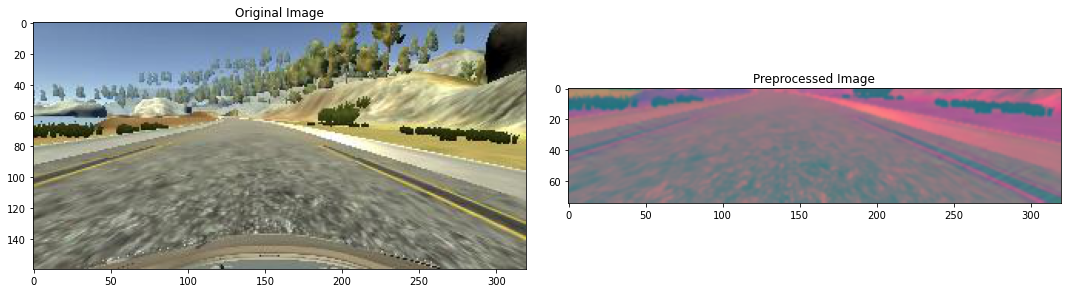

In [15]:
def img_preprocess_step4(img):
  img = mpimg.imread(img)
  # start modify the img
  img = img[60:135, :, :]
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  img = cv2.GaussianBlur(img, (3, 3), 0)
  return img

# image = image_paths[100]
# original_image = mpimg.imread(image)
preprocessed_image = img_preprocess_step4(image)
#
fig, axs = plt.subplots(1, 2, figsize = (15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')

As you see, we geta much more smooth image with less noise. This helps our model extract features from our image because it has to deal with less noise. 

we are now going to resize our image and decrease it size, this will allow for faster computations as a smaller image is easier to work with. conveniently we have a 'cv2.resize' command, which allows you to do exactly that. the size we choose is 200X66, not only is this image smaller, it also matches the image size of the input images used by the nvidia model architecture. The image size is not necessary however it will help us remain consistent.

Text(0.5, 1.0, 'Preprocessed Image')

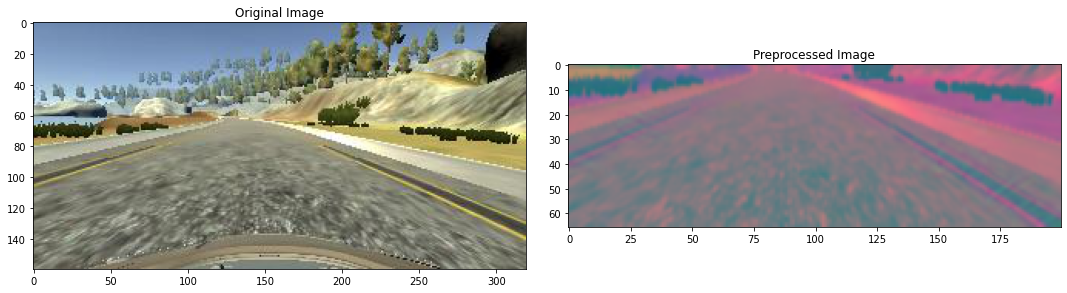

In [16]:
def img_preprocess_step5(img):
  img = mpimg.imread(img)
  # start modify the img
  img = img[60:135, :, :]
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  img = cv2.GaussianBlur(img, (3, 3), 0)
  img = cv2.resize(img, (200, 66))
  return img

# image = image_paths[100]
# original_image = mpimg.imread(image)
preprocessed_image = img_preprocess_step5(image)
#
fig, axs = plt.subplots(1, 2, figsize = (15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')

Now finally we have one last preprocessing technique to add to our function and it is the familiar normalization process, we simply take our image and divide it by 255 and once again we store it inside of our img.

Text(0.5, 1.0, 'Preprocessed Image')

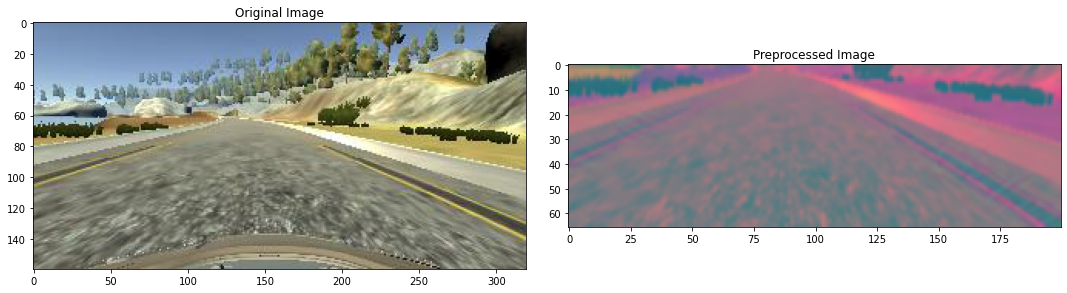

In [17]:
def img_preprocess_step6(img):
  img = mpimg.imread(img)
  # start modify the img
  img = img[60:135, :, :]
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  img = cv2.GaussianBlur(img, (3, 3), 0)
  img = cv2.resize(img, (200, 66))
  img = img/255
  return img

# image = image_paths[100]
# original_image = mpimg.imread(image)
preprocessed_image = img_preprocess_step6(image)
#
fig, axs = plt.subplots(1, 2, figsize = (15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')

 Plotting the final image is not important as normalization has no visual impact on our image. So now we have officially defiend our preprocessing function and we are ready to move on and actually preprocess our data, now having fully defined our function we nedd to run our dataset through it.
 Let's first start by preprocessing our training data sets and we will move on to our validation and testing set afterwards, we are going to use the map function all over again. what this do iterate entire array and for every element of the array that loops through it returned a new element based on the specified function that is executed for each item in the array, ultimiately creating an array with an updated the function we are going to use to update each item is 'img_preprocess_step6' and we are going through eniter X-train dataset to ensure that all of our training images are processed correctly where each image from the array will go into the function as a parameter and is preprocessed and then return of an updated value of the array. Now the 'map' function will return the preprocessed images in the format of a list, therefore we can easily use the 'list' function to store the returned values and finally we need to format this list as an array before we can store it inside of our X_train variable and so using np.array() on our list allows us to get our images inside the numpy array, and finally we can store this inside of our X_train array variable.
using the same process we can preprocess our validation.

In [0]:
X_train = np.array(list(map(img_preprocess_step6, X_train)))
X_valid = np.array(list(map(img_preprocess_step6, X_valid)))

Shape X train:  (1010, 66, 200, 3)


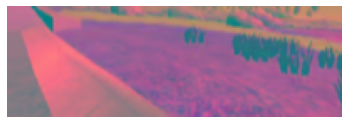

In [19]:
plt.imshow(X_train[random.randint(0, len(X_train) - 1)])
plt.axis('off')
print('Shape X train: ' , X_train.shape) # 3 channel of size 200x66 and 1010 images


**Defining Nvidia Model**
We are ready to design our model architecture. In the past we use Lenet model to classify our minist dataset however this Lenet model was not effective in classifying our traffic sign dataset it you remember for this reason we had to modify our model to properly classify the traffic signs. However with behavioral cloning our dataset is more complex than any of the other database that we have dealt with before. The mnist images were 28x28, the traffics sign images were 32x32. However now we are dealing with images that have a dimension of 200x66. futhermore while our mnist dataset at 60k training images and our traffic sign had 35k training images our current dataset only has 1010 images to train with. And finally while our previous codes dealt with classification problems our behavioral cloning code simply has to return the appropraite steering angle which is regression type example. and for all these reasons we are going to needa much more capable model. A popular model used for behavioral cloning is called the nvidia model. This model was proposed by nvidia. We are going to use this model as it has proven to be effective for behavioral cloning and it also has to be implemented in real life self-driving cars.

The architecture of the nvidia model can be seen ... and so what we will do is start by defining our 'nvidia_model' and as always we begin by creating our model architecture, we need to define our model object as 'Sequential' class. And now we can begin the architecture of our model as you can see the nvidia model starts with an input plane which consists of our 66x200 by UV images and these images are then normalized in the architecture. However we are going to skip this step as much as we have already normalized our data outside of our model. The normalized data is then passed into a convolutional layer. so lets use the typical model and add our convolution to the layer. nvidia model makes use of 24 filters inside this convolutional layer along with a kernel of 5x5 and then that is the srgument we are going to feed the convolutional network is less familiar, we are going to introduce something called 'subsampling', this function simply refers to the stride length of our kernel as it processes through our image. in the past we had small images so we use a strike length of one which means that the kernel would translate one pixel out of time. Now that we have larger images we can afford to increase the stride length as we have many more pixels to process through, this will also result in quicker computation. so for this reason we will use an argument of 2x2 for our 'subsampling' function and the first number essentially means that as our kernel translates horizontally it will move 2 pixels ata time, similarly the 2nd number means that as our kernel is translated vertically it will move 2 pixels down rather than the default one. And as always we are not going to make use the padding argument in the convolution layers, this means that we won't be using any padding on our images as the edges of most of our images are not very important to consider. and now as this layer is our first layer we also need to define an input shape for our model, this is simply going to be the shape of our input images which recall 66x200x3. and finally our last argument is going to be the activation function, which we use 'relu' function.

our snd convolution2D layer, as we see on nvidia diagram, the 2nd convolutional layer is supposed to have 36 filters with a kernel size of 5x5 and we use the same subsampling function witha stride length of 2x2 and we conclude the layer with the activation is equal to 'relu'.

And the nvidia model shows that we have 3 more convolutional layer in our network. So our 3rd convolutional layer looks exactly like our 2nd layer except that it has 12 additional filter, therefore we replace 36 to 48. and on 5th, 6th layers, they are identical with 64 filters with a 3x3 kernal size instead of the 5x5. Due all of the convolutions that our image has already gone through at this point its dimensions have decreased significantly. for this reason we are going to remove the subsampling in our 4th and 5th. we removed the subsampling skipping pixels is no longer necessary at this point here so we can stick to the default stride length of one.

The next layer we add is the flattened layer, this layer is going to take in our output array from our previous convolutional layer and convert it into a 1D array so that it can be fed into our fully connected layers that follow. our last convolutional layer outputs an array shape of 1x18x64, if you were to do the math from here up until here and now flattening this array would result in a 1D shape of 1152 pixels, if you were to simply multiply 18*64. So lets use model and add the flatten layer.
And next we simply add 3 dense fully connected layers. Where the 1st dense layer has 100 nodes and the 2nd dense layer is going to have 50 nodes, and the 3rd dense layer will have 10 nodes. All of these dense layer will use the same 'relu' activation function.

And finally we end the arhitecture of our nvidia model with a dense layer containing a single output node, which will output the predicted steering angle for our self-driving car.

Then we compile our architecture before we send it out being trained. And as thi is a regression type example the error metric we will be using is the mean squared error, and we will use the fmiliar optimizer 'adam' with the learning rate of 0.001, here we are using a relatively low learing rates as this can help improve the accuracy.



However before we can move forward we need to ensure that our model will not overfit to our training data. previously we were used 'dropout' layers to prevent overfitting of our data and we will continue to do so in this  model. dropout layers recall set the input of a random fraction of nodes to zero during each update, this helps the model generalize the training data as it is forced to use a variety of comination of nodes to learn from the same data. What we are going to do is just separate the convolutional layers from the fully connected layers, and right after the last convolution layers we are going to add model dropout, and the 2nd one right after our first fully connected layer as this layer has a large number of parameters and finally we will feed an argument of 0.5 into both Dropout layers which means that within each of these layers randomly turn 50% of thier inputs, they recieved to zero and we can fanilly finished our nvidia model by simply returning our entire model object.

In [0]:
def nvidia_model_with_relu():
  model = Sequential()
  model.add(Convolution2D(24, 5, 5, subsample = (2, 2), input_shape = (66, 200, 3), activation = 'relu'))
  model.add(Convolution2D(36, 5, 5, subsample = (2, 2), activation = 'relu'))
  model.add(Convolution2D(48, 5, 5, subsample = (2, 2), activation = 'relu'))    
  model.add(Convolution2D(64, 3, 3, activation = 'relu'))
  model.add(Convolution2D(64, 3, 3, activation = 'relu'))
  model.add(Dropout(0.5))

  model.add(Flatten())
  model.add(Dense(100, activation = 'relu'))
  model.add(Dropout(0.5))
  model.add(Dense(50 , activation = 'relu'))
  model.add(Dense(10 , activation = 'relu'))
  model.add(Dense(1))

  optimizer = Adam(lr = 1e-3)
  model.compile(loss = 'mse', optimizer = optimizer)
  return model

Now we can define our model by calling 'nvidia_model' then print a 'model.summary' which will give us an in depth summary of all the parameters inside our model

In [21]:
model = nvidia_model_with_relu()
print(model.summary())





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), input_shape=(66, 200, ..., activation="relu", strides=(2, 2))`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="relu", strides=(2, 2))`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="relu", strides=(2, 2))`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3),

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 18, 64)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)             

As we can see for the summary, we have the 5 convolutional layers the we added at the beginning of our model along with the appropriate number of filters at each layer was expected these layers are followed by a dropout layer and now the next layer is flatten layer which falttens the output from our last convolutional layer to then use it in the dense layer that follows, and finally we can see our final 4 Dense layers including our last output which contains only s single node. There is also a dropout layer between our first dense layer and the 2nd dense layer to prevent against overfitting and the total trainable parameters of our model results in 252219. The bulk of which can be found in our very first dense layer were last 3 convolutional layers also quite a few parameters due to the large number of filters being used.

Alright now we can move on and begin the model training process. We are going to use 'model.fit()' to define our training parameters and first of all we are going to do is import  our training data X_train and our training data labels y_train and we then define the amount of epochs we want to run, we will use 30. This is relatively a pretty high number of epochs, owever since we have much less data in this database we are going to require moreepochs for our training to be effective, and next we need to import our 'validation_data' for our network to use and we can simply set the equal to (X_valid, y_valid) which contains the respective labels, we also use the batch_size is equal to 100 which is reasonable considering that our dataset has a total of only 1010 images. And finally we set 'verbose' is equal to 1 and 'shuffle' as always is equal to 1 as we have consistently done in the past and we are now fianlly ready to train our first invidia model and evaluate its performance

In [22]:
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid), batch_size=100, verbose=1, shuffle=1)




Train on 1010 samples, validate on 253 samples
Epoch 1/30





1010/1010 [==============================] - 8s 8ms/step - loss: 0.1194 - val_loss: 0.1170
Epoch 2/30
1010/1010 [==============================] - 7s 7ms/step - loss: 0.1167 - val_loss: 0.1182
Epoch 3/30
1010/1010 [==============================] - 7s 7ms/step - loss: 0.1168 - val_loss: 0.1180
Epoch 4/30
1010/1010 [==============================] - 7s 7ms/step - loss: 0.1165 - val_loss: 0.1178
Epoch 5/30
1010/1010 [==============================] - 7s 7ms/step - loss: 0.1163 - val_loss: 0.1177
Epoch 6/30
1010/1010 [==============================] - 7s 7ms/step - loss: 0.1163 - val_loss: 0.1177
Epoch 7/30
1010/1010 [==============================] - 7s 7ms/step - loss: 0.1164 - val_loss: 0.1176
Epoch 8/30
1010/1010 [==============================] - 7s 7ms/step - loss: 0.1163 - val_loss: 0.1174
Epoch 9/30
1010/1010 [==============================] - 7s 7ms/step - loss: 0.1162 - val_loss: 0.1172
Epoch 10/30
1010/1010 [====

I was noticing something as the model was being trained in running this model we can see that the epochs are going by quite quickly which makes sense as we have such little training data for our model to train on, however as the epochs progress we are not seeing much change in our loss values, both our training loss and validation loss are stagnant which is not a good sign, the epochs seem to continue on, however our loss do not seem to be converging to a lower value. 
After finish this, we are going to plot our data to analyze what happend.



Text(0.5, 0, 'Epochs')

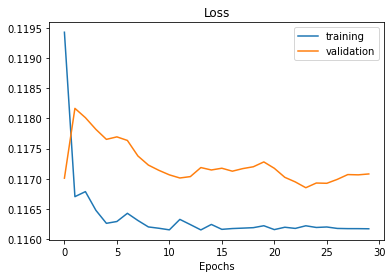

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epochs')

The above plot show that it is not good, as you can see there is a big gap between our training loss and our validation loss and this gap also never seems to close. and our loss values remain relatively consistent. This is indicative of a poorly trained model. So how to fix this?

The issue appears to be comming from our choice of actiavtion function. The 'relu' activation function is a reliable and a quick activation function and as mentioned earlier we replaced the sigmoid activation function with the relu function to avoid the vanishing gradient problem in more complex NN, however the 'relu' function has shortcomings of its own the use of the 'relu' function can sometimes cause a phenomenon called a dead relu. This is when a node in the NN essentially dies and only feeds a value of 0 to the nodes that follow it. This phenomenon can be explained by visualizing the structure of the relu function.


if the value fed into the 'relu' is less than zero then the function returns zero, however if the value fed into the 'relu' is 0 or greater than the 'relu' function simply returns the same value back. Anoter important thing to notice is that the gradient of the 'relu' function in the +ve region is 1, however the gradient of the 'relu' function in the -ve region is 0. Therefore if a node gets an input of a -ve number it will return a value 0. However since the gradient at this point is 0 then the weight of this node will never be changed as a back propagation uses the gradient value to change the weight values of the nodes. This means that the node always receive a -ve input and will always feed forward the value of 0 without ever learning. If enough 'relu's die then the loss of the model will remain stagnant and never decrease. This is the exact phenomenon that we saw happen. 
However luck for us there is a solution to this, we can replace the 'relu' activation function with something called an 'elu' activation function. The 'elu' looks a lot like the 'relu', well it looks exactly like the 'relu' in the +ve region, however in the -ve region the 'elu' returns a -ve number. Further more unlike the 'relu', 'elu' has a none-zero gradient value in the -ve region. This means that the 'elu' function always has the chance to recover and fix its weight parameters to decrease its error, meaning it always remains capable of learning and contributing to the model. Unlike the 'relu' which can essentially die. 

In [0]:
def nvidia_model_with_elu():
  model = Sequential()
  model.add(Convolution2D(24, 5, 5, subsample = (2, 2), input_shape = (66, 200, 3), activation = 'elu'))
  model.add(Convolution2D(36, 5, 5, subsample = (2, 2), activation = 'elu'))
  model.add(Convolution2D(48, 5, 5, subsample = (2, 2), activation = 'elu'))    
  model.add(Convolution2D(64, 3, 3, activation = 'elu'))
  model.add(Convolution2D(64, 3, 3, activation = 'elu'))
  model.add(Dropout(0.5))

  model.add(Flatten())
  model.add(Dense(100, activation = 'elu'))
  model.add(Dropout(0.5))
  model.add(Dense(50 , activation = 'elu'))
  model.add(Dense(10 , activation = 'elu'))
  model.add(Dense(1))

  optimizer = Adam(lr = 1e-3)
  model.compile(loss = 'mse', optimizer = optimizer)
  return model

In [28]:
model = nvidia_model_with_elu()
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 1, 18, 64)         36928     
_________________________________________________________________
dropout_5 (Dropout)          (None, 1, 18, 64)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1152)             

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), input_shape=(66, 200, ..., activation="elu", strides=(2, 2))`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="elu", strides=(2, 2))`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="elu", strides=(2, 2))`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="elu")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), act

In [29]:
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid), batch_size=100, verbose=1, shuffle=1)

Train on 1010 samples, validate on 253 samples
Epoch 1/30
1010/1010 [==============================] - 8s 8ms/step - loss: 1.1298 - val_loss: 0.2384
Epoch 2/30
1010/1010 [==============================] - 7s 7ms/step - loss: 0.1639 - val_loss: 0.1390
Epoch 3/30
1010/1010 [==============================] - 7s 7ms/step - loss: 0.1381 - val_loss: 0.1124
Epoch 4/30
1010/1010 [==============================] - 7s 7ms/step - loss: 0.1210 - val_loss: 0.1116
Epoch 5/30
1010/1010 [==============================] - 7s 7ms/step - loss: 0.1152 - val_loss: 0.1084
Epoch 6/30
1010/1010 [==============================] - 7s 7ms/step - loss: 0.1086 - val_loss: 0.1035
Epoch 7/30
1010/1010 [==============================] - 7s 7ms/step - loss: 0.1022 - val_loss: 0.0983
Epoch 8/30
1010/1010 [==============================] - 7s 7ms/step - loss: 0.0927 - val_loss: 0.0899
Epoch 9/30
1010/1010 [==============================] - 7s 7ms/step - loss: 0.0816 - val_loss: 0.0853
Epoch 10/30
1010/1010 [============

Text(0.5, 0, 'Epochs')

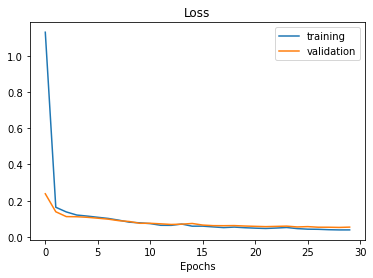

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epochs')

It is obvious that we fixed our dying 'relu' problem as our last values converge to much lower values that before. This means that our transition to the 'elu' activation function was effective. The graph actually looks very nice for our data, apart from a samll indication of overfitting near the end of the training process this looks very promising and we are very close to having an effective behavioral cloning model in order to finalize our model and eliminate the overfitting completely, we are going to add two more 'dropout' layers to our model:

In [0]:
def nvidia_model_with_elu_add_dropouts():
  model = Sequential()
  model.add(Convolution2D(24, 5, 5, subsample = (2, 2), input_shape = (66, 200, 3), activation = 'elu'))
  model.add(Convolution2D(36, 5, 5, subsample = (2, 2), activation = 'elu'))
  model.add(Convolution2D(48, 5, 5, subsample = (2, 2), activation = 'elu'))    
  model.add(Convolution2D(64, 3, 3, activation = 'elu'))

  model.add(Convolution2D(64, 3, 3, activation = 'elu'))
  model.add(Dropout(0.5))

  model.add(Flatten())

  model.add(Dense(100, activation = 'elu'))
  model.add(Dropout(0.5))

  model.add(Dense(50 , activation = 'elu'))
  model.add(Dropout(0.5))

  model.add(Dense(10 , activation = 'elu'))
  model.add(Dropout(0.5))
  
  model.add(Dense(1))

  optimizer = Adam(lr = 1e-3)
  model.compile(loss = 'mse', optimizer = optimizer)
  return model

In [32]:
model = nvidia_model_with_elu_add_dropouts()
print(model.summary())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), input_shape=(66, 200, ..., activation="elu", strides=(2, 2))`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="elu", strides=(2, 2))`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="elu", strides=(2, 2))`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="elu")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), act

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 1, 18, 64)         36928     
_________________________________________________________________
dropout_7 (Dropout)          (None, 1, 18, 64)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 1152)             

In [33]:
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid), batch_size=100, verbose=1, shuffle=1)

Train on 1010 samples, validate on 253 samples
Epoch 1/30
1010/1010 [==============================] - 8s 8ms/step - loss: 1.1692 - val_loss: 0.1204
Epoch 2/30
1010/1010 [==============================] - 7s 7ms/step - loss: 0.2560 - val_loss: 0.1172
Epoch 3/30
1010/1010 [==============================] - 7s 7ms/step - loss: 0.2111 - val_loss: 0.1112
Epoch 4/30
1010/1010 [==============================] - 7s 7ms/step - loss: 0.1573 - val_loss: 0.1077
Epoch 5/30
1010/1010 [==============================] - 7s 7ms/step - loss: 0.1465 - val_loss: 0.1044
Epoch 6/30
1010/1010 [==============================] - 7s 7ms/step - loss: 0.1374 - val_loss: 0.1162
Epoch 7/30
1010/1010 [==============================] - 7s 7ms/step - loss: 0.1238 - val_loss: 0.1030
Epoch 8/30
1010/1010 [==============================] - 7s 7ms/step - loss: 0.1167 - val_loss: 0.0932
Epoch 9/30
1010/1010 [==============================] - 7s 7ms/step - loss: 0.1132 - val_loss: 0.0896
Epoch 10/30
1010/1010 [============

Text(0.5, 0, 'Epochs')

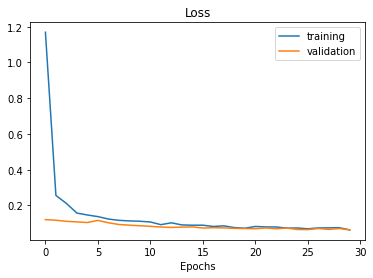

In [34]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epochs')

Our model just converged as expected and going below and running the plot show us the we have completely prevented overfitting of our model.
If your model is not converging properly or your plot does not match mine you can attempt to retain your model as on the rare occasions the model can diverge early in the training process. And moving forward, we have effectively created a model that can look at an image from the car and give a prediction for the required steering angle of the car for it to drive properly this sounds very good in theory, But lets evaluate our model by putting it to the test before we can use this model with our self-driving car simulator we need to add code to save our model. 

In [0]:
model.save('model.h5')

Then we need to download the saved model. 

In [0]:
from google.colab import files
files.download('model.h5')

Now before we can use our model with car simulator we need to code an additional algorithm that will allow our mdel to communicate with our self-driving car simulator, we caal it 'drive.py', and we are going to save it alongside of our model. This file is going to allow data transfer between our model and our simulator and it will allow us to control certain parameters in our simulation.